<h2>Installing required packages</h2>

In [1]:
#!pip install pennylane --upgrade

In [2]:
#!pip install tensorflow

In [3]:
#!pip install keras

<h2>Imports and dataset</h2>

In [4]:
import pennylane as qml
from pennylane import numpy as np

In [5]:
from keras.models import Sequential
from keras.layers import Dense

In [6]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [7]:
import json
from Filters import *
from Data_load import data_load
import matplotlib.pyplot as plt

import keras

from utils import *

import time

## Import the images
data = data_load()
train_images, train_labels, test_images, test_labels = data.data_mnist()

6000


In [8]:
print("shape of train images", train_images[0].shape)
print("shape of test images", test_images[0].shape)

shape of train images (28, 28, 1)
shape of test images (28, 28, 1)


In [9]:
print("length of train images", len(train_images))
print("length of test images", len(test_images))

length of train images 6000
length of test images 1000


In [10]:
# This function returns the modified dataset
# It is a script to get a dataset of 2 labels only
def trainTestData(train_images, train_labels, test_images, test_labels, label1, label2, n_train, n_test):
    n_train_images, n_train_labels, n_test_images, n_test_labels = [], [], [], []
    i = 0
    while (n_train > 0 and i < len(train_images)):
        if train_labels[i] == label1:
            n_train_images.append(train_images[i])
            n_train_labels.append(label1)
            n_train -= 1
        if train_labels[i] == label2:
            n_train_images.append(train_images[i])
            n_train_labels.append(label2)
            n_train -= 1
        i = i+1
    i = 0
    while(n_test>0 and i < len(test_images)):
        if test_labels[i] == label1:
            n_test_images.append(test_images[i])
            n_test_labels.append(label1)
            n_test -= 1
        if test_labels[i] == label2:
            n_test_images.append(test_images[i])
            n_test_labels.append(label2)
            n_test -= 1
        i = i+1
    return n_train_images, n_train_labels, n_test_images, n_test_labels

In [11]:
train_images, train_labels, test_images, test_labels = trainTestData(train_images, train_labels, test_images, test_labels, 3, 5, 400, 40)

In [12]:
# this functions makes the train dataset balanced
# number of images for number 3 same as that for number 5
def balanceDataSet(BAS, train_labels):
    new_train_images_3 = []
    new_train_images_5 = []

    new_train_labels_3 = []
    new_train_labels_5 = []

    for i in range(len(BAS)):
      if train_labels[i] == 3:
        new_train_images_3.append(BAS[i])
        new_train_labels_3.append(3)
      else:
        new_train_images_5.append(BAS[i])
        new_train_labels_5.append(5)
    return new_train_images_3[0:150] + new_train_images_5[0:150], new_train_labels_3[0:150] + new_train_labels_5[0:150]

In [13]:
train_images, train_labels = balanceDataSet(train_images, train_labels)
# saving the dataset for using in the other part
# to have a fair comparison of performance
org_train_images, org_train_labels, org_test_images, org_test_labels = train_images, train_labels, test_images, test_labels

In [14]:
print("length of train images", len(train_images))
print("length of test images", len(test_images))

length of train images 300
length of test images 40


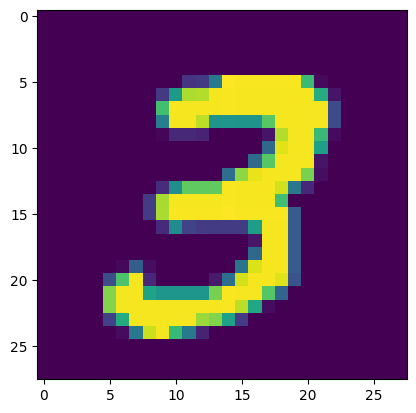

In [15]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0])

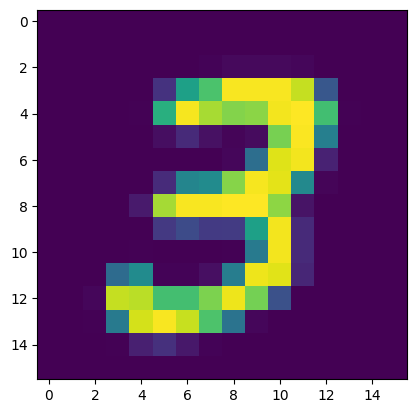

In [16]:
img_test = rescale(train_images[0], 16/28)
plt.imshow(img_test)

In [17]:
#resizing the train and test datasets from (28, 28) to (16, 16)
BAS = []
for img in train_images:
  img = rescale(img, 16/28, anti_aliasing=False)
  img = img.flatten()
  BAS.append(img)

BAS_test = []
for img in test_images:
  img = rescale(img, 16/28, anti_aliasing=False)
  img = img.flatten()
  BAS_test.append(img)

In [18]:
BAS[0].shape

(256,)

In [19]:
16*16

256

In [20]:
def block(weights, wires):
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)

In [21]:
2**8 #so 8 qubits circuit needed

256

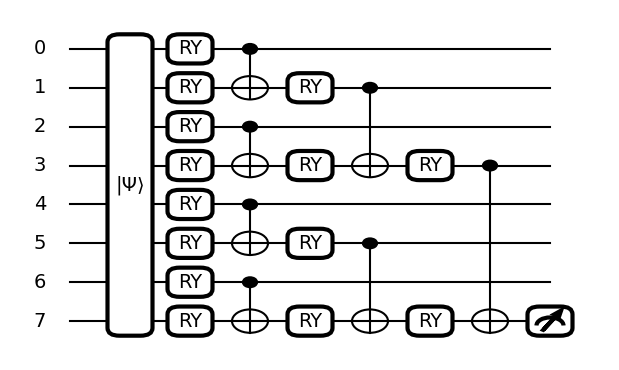

In [22]:
dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev)
def circuit(image, template_weights):
    qml.AmplitudeEmbedding(features=image, wires=range(8), normalize=True)
    qml.TTN(
        wires=range(8),
        n_block_wires=2,
        block=block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=7))

weights = np.random.random(size=[7, 2])
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(BAS[0], weights)
fig.set_size_inches((6, 3.5))

In [23]:
# defining the cost function
def costfunc(params):
    cost = 0
    for i in range(len(BAS)):
        if i < len(BAS) / 2:
            cost += circuit(BAS[i], params)
        else:
            cost -= circuit(BAS[i], params)
    return cost

In [24]:
# training the circuit parameters
x2 = np.random.random(size=[7, 2], requires_grad=True)
params = x2[:]
optimizer = qml.GradientDescentOptimizer(stepsize=0.01)

for k in range(101):
    if k % 5 == 0:
        print(f"Step {k}, cost: {costfunc(params)}")
    params = optimizer.step(costfunc, params)

Step 0, cost: 4.335501769044621
Step 5, cost: -33.93398252351568
Step 10, cost: -38.52096074647527
Step 15, cost: -38.948459913972336
Step 20, cost: -39.04561183328222
Step 25, cost: -39.115558890670926
Step 30, cost: -39.20683174002033
Step 35, cost: -39.34764389596334
Step 40, cost: -39.56100261259744
Step 45, cost: -39.85473874248992
Step 50, cost: -40.20660090197006
Step 55, cost: -40.565052622015955
Step 60, cost: -40.87627577494416
Step 65, cost: -41.114155850378474
Step 70, cost: -41.28420147040094
Step 75, cost: -41.40686222863818
Step 80, cost: -41.50242619522834
Step 85, cost: -41.58567867960928
Step 90, cost: -41.66644205916523
Step 95, cost: -41.75154556083455
Step 100, cost: -41.84646181576366


In [25]:
i = 0
train_correct = 0
for img in BAS:
  if circuit(img,params) < 0 and train_labels[i] == 3:
    train_correct += 1
  elif circuit(img,params) > 0 and train_labels[i] == 5:
    train_correct += 1
  i += 1
print("training accuracy: 300 images, 150 for letter 3 and 150 for letter 5")
print(100*train_correct/len(BAS),"%")

training accuracy: 300 images, 150 for letter 3 and 150 for letter 5
78.33333333333333 %


In [26]:
predicted = []
i = 0
test_correct = 0
for img in BAS_test:
  if circuit(img.flatten(),params) < 0:
    predicted.append(3)
  if circuit(img.flatten(),params) > 0:
    predicted.append(5)
  if circuit(img.flatten(),params) < 0 and test_labels[i] == 3:
    test_correct += 1
  elif circuit(img.flatten(),params) > 0 and test_labels[i] == 5:
    test_correct += 1
  i += 1
print("testing accuracy: 60 images")
print(100*test_correct/len(BAS_test),"%")

testing accuracy: 60 images
75.0 %


<h2>CNN on 16x16 images:</h2>

In [27]:
train_images, train_labels, test_images, test_labels = org_train_images, org_train_labels, org_test_images, org_test_labels

In [28]:
# changing the size of the train images and storing in BAS
BAS = []
for img in train_images:
    # using sickit image to rescale to (16,16)
    img = rescale(img, 16/28, anti_aliasing=False)
    img = img.reshape(16,16)
    BAS.append(img)

# changing the size of the test images and storing in BAS_test
BAS_test = []
for img in test_images:
    # using sickit image to rescale to (16,16)
    img = rescale(img, 16/28, anti_aliasing=False)
    img = img.reshape(16,16)
    BAS_test.append(img)

train_images = BAS[:]
test_images = BAS_test[:]

In [29]:
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
train_images.shape

(300, 16, 16)

In [30]:
# 256 used instead of 784 since 16*16 = 256
train_data = train_images.reshape((len(train_images), 256))

# 256 used instead of 784 since 16*16 = 256
test_data = test_images.reshape((len(test_labels), 256))


categories = np.array([3, 5])
encoded_train_labels = np.zeros((len(train_labels), len(categories)))
for i in range(len(train_labels)):
  j = np.where(categories == train_labels[i])
  encoded_train_labels[i, j] = 1

categories = np.array([3, 5])
encoded_test_labels = np.zeros((len(test_labels), len(categories)))
for i in range(len(test_labels)):
  j = np.where(categories == test_labels[i])
  encoded_test_labels[i, j] = 1

In [31]:
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(256,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.reset_states()
model.fit(train_data, encoded_train_labels, validation_split=0.2, epochs=10)

Epoch 1/10
8/8 [==============================] - 1s 50ms/step - loss: 0.6893 - accuracy: 0.5917 - val_loss: 0.7810 - val_accuracy: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 0.6705 - accuracy: 0.6292 - val_loss: 0.8136 - val_accuracy: 0.0000e+00
Epoch 3/10
8/8 [==============================] - 0s 9ms/step - loss: 0.6473 - accuracy: 0.6250 - val_loss: 0.8453 - val_accuracy: 0.0000e+00
Epoch 4/10
8/8 [==============================] - 0s 11ms/step - loss: 0.6242 - accuracy: 0.6250 - val_loss: 0.8920 - val_accuracy: 0.0000e+00
Epoch 5/10
8/8 [==============================] - 0s 12ms/step - loss: 0.5989 - accuracy: 0.6250 - val_loss: 0.9200 - val_accuracy: 0.0000e+00
Epoch 6/10
8/8 [==============================] - 0s 11ms/step - loss: 0.5769 - accuracy: 0.6250 - val_loss: 0.9276 - val_accuracy: 0.0167
Epoch 7/10
8/8 [==============================] - 0s 13ms/step - loss: 0.5519 - accuracy: 0.6417 - val_loss: 0.8815 - val_accuracy: 0.0667
Epoch 8/

In [34]:
model.evaluate(test_data, encoded_test_labels)

2/2 [==============================] - 0s 12ms/step - loss: 0.5703 - accuracy: 0.6250


[0.5702916383743286, 0.625]